## Evaluate similarity metrics for CT patterns

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random

from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"
results1_subj_limit = 2314
results_folders = ["/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1711765",
                   "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1815989"
                  ]

In [3]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,top10_tokens,top10_tokens_probs
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"[ New, the, London, 18, Toronto, Montreal...","[0.03859247639775276, 0.03803418204188347, 0.0..."
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.04142675921320915, 0.07775774598121643, 0.0..."
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.03634488210082054, 0.07916285842657089, 0.0..."
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"[ New, the, London, 18, Toronto, Montreal...","[0.03823259472846985, 0.15465885400772095, 0.0..."
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"[ New, the, London, 18, Toronto, Montreal...","[0.029023099690675735, 0.13267268240451813, 0...."


## Calculate distance values

In [16]:
from skimage.metrics import structural_similarity, normalized_root_mse, normalized_mutual_information

def get_ssim_dist(lama_scores, scores):
    #ssim of 1 means completely similar, 0 dissimilar?
    return 1-structural_similarity(im1=np.expand_dims(lama_scores, axis=2), 
                                   im2=np.expand_dims(scores, axis=2), 
                                   win_size=1,
                                   data_range=1,
                                   gaussian_weights=True,
                                   sigma=1.5,
                                   use_sample_covariance=False
                                  )

def get_norm_root_mse(lama_scores, scores):
    return normalized_root_mse(image_true=np.expand_dims(lama_scores, axis=2), image_test=np.expand_dims(scores, axis=2))

def get_norm_mutual_info(lama_scores, scores):
    # 1 - perfectly uncorrelated and 2 - perfectly correlated
    return normalized_mutual_information(image0=np.expand_dims(lama_scores, axis=2), image1=np.expand_dims(scores, axis=2))

In [7]:
def get_cos_dist(lama_scores, scores):
    lama_scores = np.nan_to_num(lama_scores/np.linalg.norm(lama_scores, axis=1)[:, np.newaxis])
    scores = np.nan_to_num(scores/np.linalg.norm(scores, axis=1)[:, np.newaxis])
    sim = np.multiply(lama_scores, scores).sum(axis=1)
    return 1-sum(sim)/len(sim)

In [8]:
import ot

def get_wasserstein(lama_scores, scores):
    return ot.sliced_wasserstein_distance(lama_scores, scores, n_projections=10000, seed=63)

def get_wasserstein_norm(lama_scores, scores):
    scores = scores/scores.sum()
    lama_scores = lama_scores/lama_scores.sum()
    return ot.sliced_wasserstein_distance(lama_scores, scores, n_projections=10000, seed=63)

def get_wasserstein_norm_min(lama_scores, scores):
    scores = (scores-scores.min())
    scores = scores/scores.sum()
    lama_scores = (lama_scores-lama_scores.min())
    lama_scores = lama_scores/lama_scores.sum()
    return ot.sliced_wasserstein_distance(lama_scores, scores, n_projections=10000, seed=63)

get_ws_dist = get_wasserstein_norm

In [9]:
def get_kl_div(lama_scores, scores):
    scores = get_normalized_scores(scores)
    lama_scores = get_normalized_scores(lama_scores)
    return sum(scipy.special.rel_entr(scores, lama_scores))
    
def get_normalized_scores(scores):
    delta = 0.000001
    scores = (scores.flatten()-scores.flatten().min()+delta)
    scores = scores/scores.sum()
    
    return scores

def get_kl_div_no_min(lama_scores, scores):
    scores = get_normalized_scores_no_min(scores)
    lama_scores = get_normalized_scores_no_min(lama_scores)
    return sum(scipy.special.rel_entr(scores, lama_scores))
    
def get_normalized_scores_no_min(scores):
    scores = scores.flatten()
    scores = scores/scores.sum()
    
    return scores

#get_kl_div = get_kl_div_no_min

In [10]:
def get_results_for_token_ix(results, token_ix, answer_for_token):
    results = dict(results)
    results["scores"] = results["scores"][:,:,token_ix]
    results["low_score"] = results["low_score"][token_ix]
    results["high_score"] = results["high_score"][token_ix]
    results["answer"] = answer_for_token #a bit hacky to get the answer as argument
    return results
    
def get_results_for_subject(results):
    # assumes that results already has been filtered by token_id
    results["scores"] = results["scores"][results["subject_range"][0]:results["subject_range"][1],:]
    results["input_tokens"] = results["input_tokens"][results["subject_range"][0]:results["subject_range"][1]]
    results["input_ids"] = results["input_ids"][results["subject_range"][0]:results["subject_range"][1]]
    results["subject_range"] = np.array([0,len(results["input_tokens"])])
    return results

In [39]:
annotated_data = pd.read_csv("/cephyr/users/lovhag/Alvis/projects/rome/data/similarity/P19_annotated_val.csv")

Run similarity metrics

In [40]:
dist_metrics = {"cos": get_cos_dist,
                "ws": get_ws_dist,
                "kl": get_kl_div,
                "ssim": get_ssim_dist,
                "nrmse": get_norm_root_mse,
                "nmi": get_norm_mutual_info
               }

dist_results = {key: [] for key in dist_metrics}

for ix, row in annotated_data.iterrows():
    if row.token_type == "any":
        token_ix = 0
        answer = queries.loc[row.lama_ix]["top10_tokens"][token_ix]
    elif row.token_type == "candidate":
        answer = queries.loc[row.lama_ix]["candidate_prediction"]
        token_ix = queries.loc[row.lama_ix]["top10_tokens"].index(answer)
        
    if row.lama_ix < results1_subj_limit:
        results_folder = results_folders[0]
    else:
        results_folder = results_folders[1]
    results_lama = np.load(os.path.join(results_folder, f"cases/{row.lama_ix}_any_mlp.npz"), allow_pickle=True)
    
    dists = {key: {"metric": key} for key in dist_metrics}
    for ix, sample_ix in enumerate([row.sample_ix_1, row.sample_ix_2]):
        proc_results_lama = get_results_for_token_ix(results_lama, token_ix, answer)
        proc_results_lama = get_results_for_subject(proc_results_lama)

        if sample_ix < results1_subj_limit:
            results_folder = results_folders[0]
        else:
            results_folder = results_folders[1]
            
        results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
        results = get_results_for_token_ix(results, token_ix, answer)
        results = get_results_for_subject(results)

        for key in dists:
            dists[key][f"ex{ix+1}"] = dist_metrics[key](proc_results_lama["scores"], results["scores"])
        
    for key in dist_results:
        dist_results[key].append(dists[key])

data = pd.DataFrame()
for key, val in dist_results.items():
    data = data.append(annotated_data.merge(pd.DataFrame(val), left_index=True, right_index=True, suffixes=(False, False)), ignore_index=True)

data = data.sort_values(by=["lama_ix", "sample_ix_1", "sample_ix_2", "token_type"], ignore_index=True)
data

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,metric,ex1,ex2
0,7,9,13,candidate,1,cos,0.004174,0.006637
1,7,9,13,candidate,1,ws,0.000512,0.000633
2,7,9,13,candidate,1,kl,0.018716,0.038002
3,7,9,13,candidate,1,ssim,0.178567,0.593005
4,7,9,13,candidate,1,nrmse,0.516961,0.849109
...,...,...,...,...,...,...,...,...
1189,5432,5438,5435,candidate,1,ws,0.000779,0.001274
1190,5432,5438,5435,candidate,1,kl,0.106105,0.180781
1191,5432,5438,5435,candidate,1,ssim,0.077364,0.109190
1192,5432,5438,5435,candidate,1,nrmse,0.678663,0.793644


## Compare distance values to annotations

In [41]:
acc_data = data.copy()
acc_data.head()

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,metric,ex1,ex2
0,7,9,13,candidate,1,cos,0.004174,0.006637
1,7,9,13,candidate,1,ws,0.000512,0.000633
2,7,9,13,candidate,1,kl,0.018716,0.038002
3,7,9,13,candidate,1,ssim,0.178567,0.593005
4,7,9,13,candidate,1,nrmse,0.516961,0.849109


In [42]:
acc_data.groupby("metric").mean()

,lama_ix,sample_ix_1,sample_ix_2,example_more_similar,ex1,ex2
metric,,,,,,
cos,1807.407035,1810.839196,1810.743719,1.81407,0.014980,0.015940
kl,1807.407035,1810.839196,1810.743719,1.81407,0.081871,0.098554
nmi,1807.407035,1810.839196,1810.743719,1.81407,1.550242,1.549734
nrmse,1807.407035,1810.839196,1810.743719,1.81407,0.848114,0.847016
ssim,1807.407035,1810.839196,1810.743719,1.81407,0.274879,0.273449
ws,1807.407035,1810.839196,1810.743719,1.81407,0.001131,0.001113


In [47]:
acc_data[acc_data.metric=="cos"][["ex1", "ex2"]].mean().mean()

0.015459832239509256

In [48]:
means = {key: acc_data[acc_data.metric==key][["ex1", "ex2"]].mean().mean() for key in dist_metrics}

def get_dist_accuracy(dist_1, dist_2, label, mean_dist):
    if label == 1:
        return int(dist_1<dist_2)
    elif label == 2:
        return int(dist_1>dist_2)
    elif label == 0:
        return int(dist_1>mean_dist and dist_2>mean_dist)
    elif label == 3:
        return int(abs(np.log10(dist_1)-np.log10(dist_2))<0.5)
    else:
        raise Exception("Annotated score not valid.")

In [60]:
acc_data["score"] = None
for key in dist_metrics:
    key_mask = acc_data.metric==key
    acc_data.loc[key_mask, "score"] = acc_data[key_mask].apply(lambda row: get_dist_accuracy(row.ex1, 
                                                                                                                 row.ex2, 
                                                                                                                 row.example_more_similar, 
                                                                                                                 means[key]), 
                                                                                   axis=1
                                                                                  )
acc_data["score"] = acc_data.score.astype("float")
acc_data.head()

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,metric,ex1,ex2,score
0,7,9,13,candidate,1,cos,0.004174,0.006637,1.0
1,7,9,13,candidate,1,ws,0.000512,0.000633,1.0
2,7,9,13,candidate,1,kl,0.018716,0.038002,1.0
3,7,9,13,candidate,1,ssim,0.178567,0.593005,1.0
4,7,9,13,candidate,1,nrmse,0.516961,0.849109,1.0


In [63]:
acc_data.groupby(["token_type", "metric"]).score.mean()

token_type  metric
any         cos       0.562500
            kl        0.604167
            nmi       0.552083
            nrmse     0.645833
            ssim      0.593750
            ws        0.541667
candidate   cos       0.864078
            kl        0.873786
            nmi       0.504854
            nrmse     0.854369
            ssim      0.766990
            ws        0.893204
Name: score, dtype: float64

In [68]:
tmp_data = acc_data.copy()
tmp_data["example_more_similar"] = tmp_data.example_more_similar.replace([1,2], "1 or 2")
tmp_data[tmp_data.example_more_similar=="1 or 2"].groupby(["metric", "token_type"]).score.agg(["mean", "count"]) #.agg(["mean", "std"])

mean  count
metric token_type                 
cos    any         0.742857     35
       candidate   0.946429     56
kl     any         0.685714     35
       candidate   0.892857     56
nmi    any         0.342857     35
       candidate   0.160714     56
nrmse  any         0.657143     35
       candidate   0.821429     56
ssim   any         0.714286     35
       candidate   0.839286     56
ws     any         0.628571     35
       candidate   0.910714     56

In [70]:
tmp_data[tmp_data.example_more_similar==0].groupby(["metric", "token_type"]).score.agg(["mean", "count"]) #.agg(["mean", "std"])

mean  count
metric token_type                 
cos    any         0.071429     28
       candidate   0.400000      5
kl     any         0.321429     28
       candidate   0.600000      5
nmi    any         0.285714     28
       candidate   0.200000      5
nrmse  any         0.500000     28
       candidate   0.600000      5
ssim   any         0.500000     28
       candidate   0.800000      5
ws     any         0.035714     28
       candidate   0.400000      5

In [71]:
tmp_data[tmp_data.example_more_similar==3].groupby(["metric", "token_type"]).score.agg(["mean", "count"]) #.agg(["mean", "std"])

mean  count
metric token_type                 
cos    any         0.787879     33
       candidate   0.809524     42
kl     any         0.757576     33
       candidate   0.880952     42
nmi    any         1.000000     33
       candidate   1.000000     42
nrmse  any         0.757576     33
       candidate   0.928571     42
ssim   any         0.545455     33
       candidate   0.666667     42
ws     any         0.878788     33
       candidate   0.928571     42

### Error cases

In [15]:
tmp_data = acc_data[acc_data.example_more_similar.isin([1,2])].copy()
cos_dist_error_ix = set(tmp_data[tmp_data.cos_dist_score==0].index)
ws_dist_error_ix = set(tmp_data[tmp_data.ws_dist_score==0].index)
kl_dist_error_ix = set(tmp_data[tmp_data.kl_dist_score==0].index)

common_error_ix = (cos_dist_error_ix.intersection(ws_dist_error_ix).union(
    cos_dist_error_ix.intersection(kl_dist_error_ix).union(
        ws_dist_error_ix.intersection(kl_dist_error_ix)))
                  )
print(f"There are {len(common_error_ix)} common error cases.")
print(f"Total number of samples is {len(tmp_data)}.")

There are 8 common error cases.
Total number of samples is 90.


In [16]:
len(cos_dist_error_ix)

7

In [17]:
len(ws_dist_error_ix)

10

In [18]:
len(kl_dist_error_ix)

9

In [19]:
common_error_ix

{51, 53, 59, 83, 141, 174, 181, 192}

In [20]:
cos_dist_error_ix-common_error_ix

{164}

In [21]:
ws_dist_error_ix-common_error_ix

{1, 14}

In [22]:
kl_dist_error_ix-common_error_ix

{8, 115, 125, 161}

## Plot error cases

In [23]:
def plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname):
    with plt.rc_context():
        #fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=8)
        cb = plt.colorbar(h, ax=ax)
        cb.ax.tick_params(labelsize=8)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=8)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        #else:
        #    plt.show()
            
def plot_trace_heatmap(result, ax, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    high_score = None #result["high_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname)
 

SAMPLE 4 - Example 0 more similar
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) cos dist: 0.0164✅, ws dist: 0.00060❌, kl dist: 0.1187✅
---------------------------------------------------------------------------------------------------------


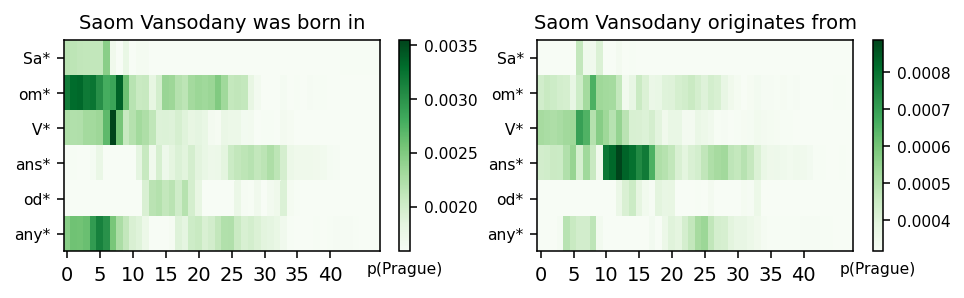

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) cos dist: 0.0229✅, ws dist: 0.00066❌, kl dist: 0.1302✅
---------------------------------------------------------------------------------------------------------


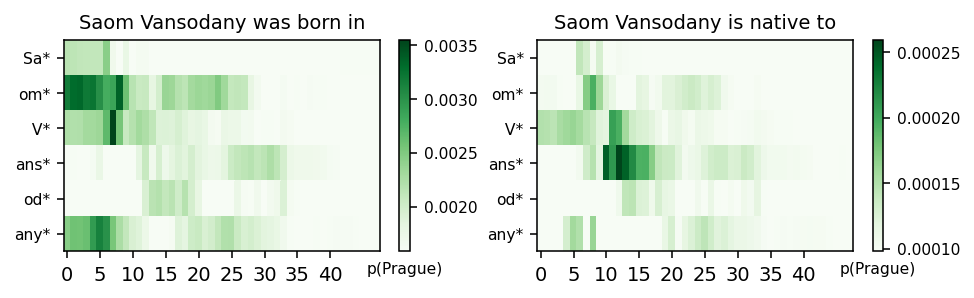

In [24]:
ix = 4
row = acc_data.loc[ix]
print("=========================================================================================================")
print(f"SAMPLE {ix} - Example {row.example_more_similar} more similar")
print("=========================================================================================================")

if row.token_type == "any":
    token_ix = 0
    answer = queries.loc[row.lama_ix]["top10_tokens"][token_ix]
elif row.token_type == "candidate":
    answer = queries.loc[row.lama_ix]["candidate_prediction"]
    token_ix = queries.loc[row.lama_ix]["top10_tokens"].index(answer)

if row.lama_ix < results1_subj_limit:
    results_folder = results_folders[0]
else:
    results_folder = results_folders[1]
results_lama = np.load(os.path.join(results_folder, f"cases/{row.lama_ix}_any_mlp.npz"), allow_pickle=True)

for ix, sample_ix in enumerate([row.sample_ix_1, row.sample_ix_2]):
    cos_correct = "✅" if row.cos_dist_score==1 else "❌"
    cos_str = f"cos_dist_ex{ix+1}"
    ws_correct = "✅" if row.ws_dist_score==1 else "❌"
    ws_str = f"ws_dist_ex{ix+1}"
    kl_correct = "✅" if row.kl_dist_score==1 else "❌"
    kl_str = f"kl_dist_ex{ix+1}"
    print("---------------------------------------------------------------------------------------------------------")
    print(f"Example {ix+1} (top {row.token_type} token) cos dist: {row[cos_str]:.4f}{cos_correct}, ws dist: {row[ws_str]:.5f}{ws_correct}, kl dist: {row[kl_str]:.4f}{kl_correct}")
    print("---------------------------------------------------------------------------------------------------------")

    proc_results_lama = get_results_for_token_ix(results_lama, token_ix, answer)
    proc_results_lama = get_results_for_subject(proc_results_lama)
    
    if sample_ix < results1_subj_limit:
        results_folder = results_folders[0]
    else:
        results_folder = results_folders[1]
    results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
    results = get_results_for_token_ix(results, token_ix, answer)
    results = get_results_for_subject(results)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
    plot_trace_heatmap(proc_results_lama, axs[0])
    axs[0].set_title(queries.iloc[row.lama_ix].prompt)
    axs[0].title.set_size(10)
    plot_trace_heatmap(results, axs[1])
    axs[1].set_title(queries.iloc[sample_ix].prompt)
    axs[1].title.set_size(10)
    plt.show()

## Further investigations

### Histograms

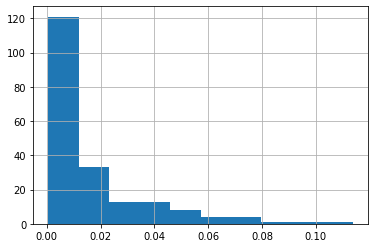

In [25]:
annotated_data.cos_dist_ex1.hist()
plt.show()

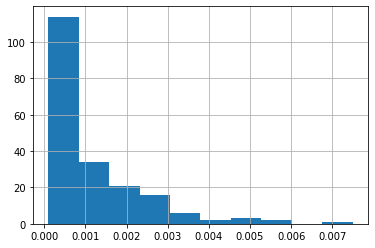

In [26]:
annotated_data.ws_dist_ex1.hist()
plt.show()

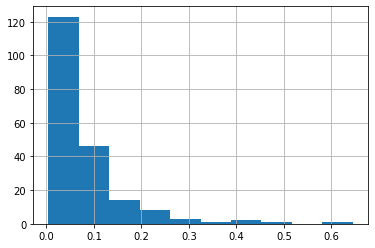

In [27]:
annotated_data.kl_dist_ex1.hist()
plt.show()

### Score correlations

In [28]:
annotated_data[["cos_dist_ex1", "ws_dist_ex1", "kl_dist_ex1"]].corr()

,cos_dist_ex1,ws_dist_ex1,kl_dist_ex1
cos_dist_ex1,1.000000,0.794694,0.513883
ws_dist_ex1,0.794694,1.000000,0.403947
kl_dist_ex1,0.513883,0.403947,1.000000


In [29]:
annotated_data[["cos_dist_ex2", "ws_dist_ex2", "kl_dist_ex2"]].corr()

,cos_dist_ex2,ws_dist_ex2,kl_dist_ex2
cos_dist_ex2,1.000000,0.768963,0.475291
ws_dist_ex2,0.768963,1.000000,0.388458
kl_dist_ex2,0.475291,0.388458,1.000000


### Correlation with annotations

Get distance differences for pairs.

In [30]:
dist_dict = {"cos": ["cos_dist_ex1", "cos_dist_ex2"], 
             "ws": ["ws_dist_ex1", "ws_dist_ex2"], 
             "kl": ["kl_dist_ex1", "kl_dist_ex2"]
            }
data = annotated_data.copy()
for key, value in dist_dict.items():
    data[f"{key}_dist_diff"] = data[value[0]]-data[value[1]]
data

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,cos_dist_ex1,cos_dist_ex2,ws_dist_ex1,ws_dist_ex2,kl_dist_ex1,kl_dist_ex2,cos_dist_diff,ws_dist_diff,kl_dist_diff
0,294,295,297,candidate,1,0.004821,0.031960,0.000507,0.001421,0.046047,0.147897,-0.027139,-9.137812e-04,-0.101850
1,4844,4845,4848,any,2,0.002468,0.002204,0.000453,0.000453,0.034575,0.033199,0.000264,-1.613879e-07,0.001376
2,4529,4531,4534,any,1,0.002807,0.035055,0.000341,0.001143,0.039710,0.406125,-0.032248,-8.017322e-04,-0.366415
3,5054,5058,5057,any,1,0.001534,0.003197,0.000374,0.000522,0.025904,0.082045,-0.001663,-1.484627e-04,-0.056141
4,1862,1868,1865,candidate,0,0.016382,0.022922,0.000598,0.000655,0.118698,0.130161,-0.006540,-5.776014e-05,-0.011464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,651,652,653,any,0,0.001794,0.001611,0.000381,0.000357,0.089338,0.083490,0.000183,2.443441e-05,0.005848
195,133,136,134,any,2,0.001223,0.000633,0.000206,0.000128,0.059159,0.024212,0.000590,7.762730e-05,0.034947
196,133,136,134,candidate,2,0.008926,0.002990,0.000428,0.000319,0.031158,0.009929,0.005936,1.094861e-04,0.021228
197,266,267,272,candidate,1,0.002936,0.038096,0.000585,0.001310,0.049721,0.129746,-0.035160,-7.248856e-04,-0.080025


Get correlations for 1 and 2 annotations.

In [31]:
sub_data = data[data.example_more_similar.isin([1, 2])].copy()
sub_data["ex1_more_similar"] = sub_data["example_more_similar"].replace(2, 0)
sub_data[sub_data.token_type=="candidate"][[f"{key}_dist_diff" for key in dist_dict.keys()]+["ex1_more_similar"]].corr()

,cos_dist_diff,ws_dist_diff,kl_dist_diff,ex1_more_similar
cos_dist_diff,1.000000,0.933178,0.753170,-0.766839
ws_dist_diff,0.933178,1.000000,0.701835,-0.772215
kl_dist_diff,0.753170,0.701835,1.000000,-0.648913
ex1_more_similar,-0.766839,-0.772215,-0.648913,1.000000


In [32]:
sub_data[sub_data.token_type=="any"][[f"{key}_dist_diff" for key in dist_dict.keys()]+["ex1_more_similar"]].corr()

,cos_dist_diff,ws_dist_diff,kl_dist_diff,ex1_more_similar
cos_dist_diff,1.000000,0.911054,0.711657,-0.623835
ws_dist_diff,0.911054,1.000000,0.704115,-0.594309
kl_dist_diff,0.711657,0.704115,1.000000,-0.611167
ex1_more_similar,-0.623835,-0.594309,-0.611167,1.000000


Also check cases for which the samples are both very dissimilar, or equally similar/dissimilar to LAMA

In [ ]:
data.example_more_similar.value_counts()

In [ ]:
data.groupby(["token_type", "example_more_similar"]).agg({"cos_dist_diff": ["mean","std"], 
                                                          "ws_dist_diff": ["mean","std"], 
                                                          "kl_dist_diff": ["mean","std"]})

In [ ]:
data.groupby(["token_type", "example_more_similar"]).agg({"cos_dist_ex1": ["mean","std"], 
                                                          "ws_dist_ex1": ["mean","std"],
                                                          "kl_dist_ex1": ["mean","std"]})